# Number of depot = 2

# Number of customer = 14

# Number of vehicles per depot = 2

# Demand and serive time of all customer are given

# Location of every node is given

# Assymetric distance matrix is considered by taking random value with a specified range about euclidean distance

# Vehicle maximum allowed distance and time is considered

# Vehicle capacity is given

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as rnd
import math as mt
import docplex.mp
from docplex.mp.model import Model
from cplex.callbacks import LazyConstraintCallback, UserCutCallback
from docplex.mp.callbacks.cb_mixin import ConstraintCallbackMixin

In [2]:
veh_speed = 35
P = 0.02           # percent of mean distance for interval of distance

In [3]:
depot_coor = pd.read_excel(r'C:\Users\shikh\OneDrive - IIT Kanpur\Desktop\Shikhar\Important Documents\Vehicle Routing Project\CVRP on 16 nodes\Data Set - 2_Depot 14_Customer.xlsx', sheet_name='Depot Details')
customer_det = pd.read_excel(r'C:\Users\shikh\OneDrive - IIT Kanpur\Desktop\Shikhar\Important Documents\Vehicle Routing Project\CVRP on 16 nodes\Data Set - 2_Depot 14_Customer.xlsx', sheet_name='Customer Details')
depot_coor_copy = depot_coor.drop('Depot', axis=1)
customer_det_copy = customer_det.drop('Customer', axis=1)
depot_coor.index = list(depot_coor['Depot'])
customer_det.index = list(customer_det['Customer'])

In [4]:
all_nodes_det = pd.concat([depot_coor_copy, customer_det_copy], ignore_index=True)
all_nodes_det.insert(0, 'Node', list(range(1, len(all_nodes_det) + 1)))
all_nodes_det.index = list(range(1, len(all_nodes_det) + 1))
all_nodes_det['Demand'] = all_nodes_det['Demand'].fillna(0)
all_nodes_det['Service Time'] = all_nodes_det['Service Time'].fillna(0)
all_nodes_det['Service Time'] = all_nodes_det['Service Time'].round(2)
all_nodes_det = all_nodes_det.astype({'Demand' : 'int'})
all_nodes_det

,Node,X coordinate,Y coordinate,No of vehicles,Capacity,Max allowed distance,Max allowed time,Demand,Service Time
1,1,456,320,2.0,15.0,1600.0,40.0,0,0.00
2,2,456,480,2.0,15.0,1600.0,40.0,0,0.00
3,3,228,0,NaN,NaN,NaN,NaN,1,0.49
4,4,912,0,NaN,NaN,NaN,NaN,1,1.16
5,5,0,80,NaN,NaN,NaN,NaN,2,0.89
6,6,114,80,NaN,NaN,NaN,NaN,4,0.32
7,7,570,160,NaN,NaN,NaN,NaN,2,0.52
8,8,798,160,NaN,NaN,NaN,NaN,4,0.86
9,9,342,240,NaN,NaN,NaN,NaN,8,0.28
10,10,684,240,NaN,NaN,NaN,NaN,8,1.29


In [5]:
coor_dic = {i : (all_nodes_det['X coordinate'][i], all_nodes_det['Y coordinate'][i]) for i in all_nodes_det['Node']}

In [6]:
distance_matrix = pd.DataFrame(index=list(range(1, len(all_nodes_det) + 1)), columns=list(range(1, len(all_nodes_det) + 1)))
for i in all_nodes_det.index:
    x1, y1 = coor_dic[i]
    for j in range(i, len(all_nodes_det) + 1):
        if i == j:
            distance_matrix[i][i] = int(10e8)
            continue
        if i <= len(depot_coor) and j <= len(depot_coor):
            distance_matrix[i][j] = int(10e8)
            distance_matrix[j][i] = int(10e8)
            continue
        x2, y2 = coor_dic[j]
        euclidean_distance = np.sqrt(pow(x1 - x2, 2) + pow(y1 - y2, 2))
        distance_matrix[i][j] = rnd.randint(mt.ceil((1 - P) * euclidean_distance), mt.ceil((1 + P) * euclidean_distance))
        distance_matrix[j][i] = rnd.randint(mt.ceil(0.98 * euclidean_distance), mt.ceil(1.02 * euclidean_distance))

travel_time_matrix = (distance_matrix / veh_speed)
for i in travel_time_matrix.index:
    travel_time_matrix[i] = travel_time_matrix[i].apply(lambda x : round(x, 2))

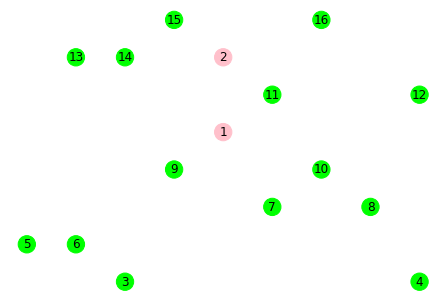

In [7]:
G = nx.DiGraph()
color_list = list()
G.add_nodes_from(list(range(1,len(all_nodes_det)+1)))
for node in G:
    if node in list(depot_coor['Depot']):
        color_list.append('pink')
    else:
        color_list.append('lime')
nx.draw(G, pos=coor_dic, node_color=color_list, with_labels=True)
plt.show()

In [8]:
m = len(depot_coor)         # Number of depot                                                                  
n = len(customer_det)       # Number of customer
L = [i for i in depot_coor['Depot']]        # List of depot
V = {i : depot_coor['No of vehicles'][i] for i in L}        # Number of vehicle at each depot
V_ = {i : [j for j in range(1, depot_coor['No of vehicles'][i] + 1)] for i in L}   # Set of vehicle for each depot as dictionary
C = [i for i in customer_det['Customer']]       # List of customers
N = [i for i in all_nodes_det['Node']]         # List of all nodes
CN = [i for i in N if i > len(L)]         # List of customer nodes
Q = depot_coor['Capacity'][1]          # Capacity of vehicle [same for all vehicles]
D = depot_coor['Max allowed distance'][1]           # Max allowed distance for vehicle [same for all vehicles]
T = depot_coor['Max allowed time'][1]        # Max allowed time [same for all vehicles]
q = {i: all_nodes_det['Demand'][i] for i in N}        # Demand dictionary of all nodes
s = {i : all_nodes_det['Service Time'][i] for i in N}        # Service time for all nodes

# Coordinates of all nodes
x_coor = {i : all_nodes_det['X coordinate'][i] for i in N}
y_coor = {i : all_nodes_det['Y coordinate'][i] for i in N}
x_coor_list = [v for v in x_coor.values()]
y_coor_list = [v for v in y_coor.values()]

In [9]:
def index_condition(i, j, k, l):
    if i != j and (i not in L or j not in L):
        if i in L and i == l:
            return True
        elif i in L and i != l:
            return False
        elif j in L and j == l:
            return True
        elif j in L and j != l:
            return False
        else:
            return True
    else:
        return False

In [10]:
index_set = [(i, j, k, l) for i in N for j in N for l in L for k in V_[l] if index_condition(i, j, k, l)]
d = {(i,j) : distance_matrix[i][j] for i, j, k, l in index_set}
t = {(i,j) : travel_time_matrix[i][j] for i, j, k, l in index_set}

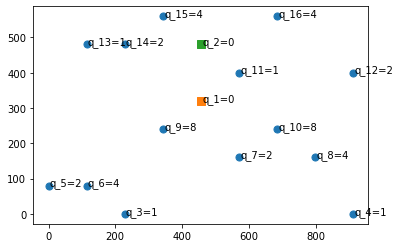

In [11]:
plt.scatter(x_coor_list, y_coor_list,s=50)
for i in N:
    plt.annotate('q_%d=%d'%(i, q[i]),(x_coor_list[i-1] + 4, y_coor_list[i-1]), fontsize=10)
plt.scatter(x_coor_list[0], y_coor_list[0], marker='s',s=50)
plt.scatter(x_coor_list[1], y_coor_list[1], marker='s',s=50)

In [12]:
model = Model(name='CVRP')

In [13]:
# for m depot and n customers and v vehicles per depot then number of binary variable = (2m + n - 3)vmn
# for m depot and n customers and v vehicles per depot then number of continous variable = n
# for m depot and n customers and v vehicles per depot then number of constraints = (m + n^2 + 3)vm + 2n

In [14]:
x = model.binary_var_dict(index_set,name='x')
u = model.continuous_var_dict(CN, ub=Q, name='u')

In [15]:
model.minimize(model.sum(d[i,j] * x[i,j,k,l] for i,j,k,l in index_set))

In [16]:
c1 = model.add_constraints((model.sum(x[i,j,k,l] for i in N if index_condition(i, j, k, l)) == 
                            model.sum(x[j,i,k,l] for i in N if index_condition(i, j, k, l)) 
                            for j in N for l in L for k in V_[l]), names='flow_constraints')

c2 = model.add_constraints((model.sum(x[i,j,k,l] for i in N for l in L for k in V_[l] if index_condition(i, j, k, l)) == 1 
                            for j in CN), names='customer_veh_constraints')

c3 = model.add_constraints((model.sum(q[j] * x[i,j,k,l] for j in N for i in N if index_condition(i, j, k, l)) <= Q 
                            for l in L for k in V_[l]), names='Capacity Constraints')

c4 = model.add_constraints((u[j] - u[i] >= q[j] - Q * (1 - x[i,j,k,l]) 
                            for i in CN for j in CN for l in L for k in V_[l] if i != j), names='sub_tour_elimination_1')

c5 = model.add_constraints((u[i]>=q[i] for i in CN), names='sub_tour_elimination_2')

c6 = model.add_constraints((model.sum(d[i,j] * x[i,j,k,l] for i in N for j in N if index_condition(i,j, k, l)) <= D 
                            for l in L for k in V_[l]), names='tour_distance_limit')

c7 = model.add_constraints((model.sum((t[i,j] + s[j]) * x[i,j,k,l] for i in N for j in N if index_condition(i,j, k, l)) <= T 
                            for l in L for k in V_[l]), names='tour_time_limit')

In [17]:
model.print_information()

Model: CVRP
 - number of variables: 854
   - binary=840, integer=0, continuous=14
 - number of constraints: 832
   - linear=832
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


In [18]:
a = model.solve(log_output=True)

Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 26 rows and 8 columns.
MIP Presolve modified 4 coefficients.
Reduced MIP has 806 rows, 846 columns, and 7040 nonzeros.
Reduced MIP has 832 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (3.53 ticks)
Probing time = 0.02 sec. (3.55 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 806 rows, 846 columns, and 7040 nonzeros.
Reduced MIP has 832 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (5.09 ticks)
Probing time = 0.02 sec. (3.54 ticks)
Clique table members: 1384.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 4 threads.
Root relaxation solution time = 0.05 sec. (2.13 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer 

In [19]:
model.solve_status

<JobSolveStatus.OPTIMAL_SOLUTION: 2>

In [20]:
model.print_solution()

objective: 4037
  x_1_7_2_1=1
  x_1_9_1_1=1
  x_2_11_2_2=1
  x_2_14_1_2=1
  x_3_1_1_1=1
  x_4_8_2_1=1
  x_5_6_1_1=1
  x_6_3_1_1=1
  x_7_4_2_1=1
  x_8_10_2_1=1
  x_9_5_1_1=1
  x_10_1_2_1=1
  x_11_12_2_2=1
  x_12_16_2_2=1
  x_13_15_1_2=1
  x_14_13_1_2=1
  x_15_2_1_2=1
  x_16_2_2_2=1
  u_3=15.000
  u_4=3.000
  u_5=10.000
  u_6=14.000
  u_7=2.000
  u_8=7.000
  u_9=8.000
  u_10=15.000
  u_11=1.000
  u_12=3.000
  u_13=11.000
  u_14=10.000
  u_15=15.000
  u_16=15.000


In [21]:
active_arcs = [a for a in index_set if x[a].solution_value > 0.9]

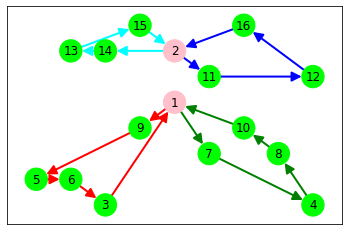

In [22]:
color_dic = {(1,1) : 'red', (1,2) : 'cyan', (2,1) : 'green', (2,2) : 'blue'}
edge_color_list = []
edge_list = []
for i,j,k,l in active_arcs:
    edge_list.append((i,j, {'veh' : k, 'depot' : l}))
G.add_edges_from(edge_list)
for edge in G.edges(data=True):
    edge_color_list.append(color_dic[edge[2]['veh'], edge[2]['depot']])
nx.draw_networkx(G, pos=coor_dic, node_size=500, node_color=color_list, edge_color=edge_color_list, width=2, arrowsize=20, with_labels=True)
plt.show()

In [23]:
tour_dis_dic, tour_time_dic = {}, {}
for l in L:
    for k in V_[l]:
        tour_dis_dic[k, l] = sum(d[i,j] * x[i,j,k,l].solution_value for i in N for j in N if index_condition(i,j, k, l) and (i,j,k,l) in active_arcs)
        tour_time_dic[k, l] = sum((t[i,j] + s[j]) * x[i,j,k,l].solution_value for i in N for j in N if index_condition(i,j, k, l) and (i,j,k,l) in active_arcs)        

In [24]:
print('Tour distance of every vehicles : \n')
for key in tour_dis_dic.keys():
    print(f'Tour distance of vehicle_{key[0]} from depot_{key[1]} is {tour_dis_dic[key[0],key[1]]}')
print('\nTour time of every vehicles : \n')
for key in tour_time_dic.keys():
    print(f'Tour time of vehicle_{key[0]} from depot_{key[1]} is {tour_time_dic[key[0],key[1]].round(2)}')

Tour distance of every vehicles : 

Tour distance of vehicle_1 from depot_1 is 1156.0
Tour distance of vehicle_2 from depot_1 is 1146.0
Tour distance of vehicle_1 from depot_2 is 728.0
Tour distance of vehicle_2 from depot_2 is 1007.0

Tour time of every vehicles : 

Tour time of vehicle_1 from depot_1 is 35.01
Tour time of vehicle_2 from depot_1 is 36.57
Tour time of vehicle_1 from depot_2 is 23.7
Tour time of vehicle_2 from depot_2 is 31.19
